Timeseries Use Case:
- Prediction / Classification
- Forecasting
- Anomaly Detection


# Init.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from datetime import datetime
import scipy.stats as stats
import scipy as sp
import pickle
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

# Data Prep.

In [2]:
data = pd.read_csv("data/iot_telemetry_data.csv")
data.info()
display(data.head())
display(data.sample(5))
display(data.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405184 entries, 0 to 405183
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ts        405184 non-null  float64
 1   device    405184 non-null  object 
 2   co        405184 non-null  float64
 3   humidity  405184 non-null  float64
 4   light     405184 non-null  bool   
 5   lpg       405184 non-null  float64
 6   motion    405184 non-null  bool   
 7   smoke     405184 non-null  float64
 8   temp      405184 non-null  float64
dtypes: bool(2), float64(6), object(1)
memory usage: 22.4+ MB


,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


,ts,device,co,humidity,light,lpg,motion,smoke,temp
315885,1.595051e+09,1c:bf:ce:15:ec:4d,0.004053,60.400002,True,0.006615,False,0.017473,25.100000
221952,1.594890e+09,b8:27:eb:bf:9d:51,0.006345,48.800000,False,0.009148,False,0.024705,22.400000
351088,1.595112e+09,00:0f:00:70:91:0a,0.005221,76.400002,False,0.007945,False,0.021250,19.000000
179603,1.594819e+09,b8:27:eb:bf:9d:51,0.004973,53.200000,False,0.007670,False,0.020466,22.800000
361269,1.595130e+09,00:0f:00:70:91:0a,0.003745,76.500000,False,0.006247,False,0.016437,19.299999


,ts,device,co,humidity,light,lpg,motion,smoke,temp
405179,1.595203e+09,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001
405180,1.595203e+09,b8:27:eb:bf:9d:51,0.005882,48.500000,False,0.008660,False,0.023301,22.200000
405181,1.595203e+09,1c:bf:ce:15:ec:4d,0.004540,75.699997,True,0.007181,False,0.019076,26.600000
405182,1.595203e+09,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001
405183,1.595203e+09,b8:27:eb:bf:9d:51,0.005914,48.400000,False,0.008695,False,0.023400,22.200000


In [3]:
# formatting timestamp
data["ts"] = data["ts"].apply(lambda x:datetime.fromtimestamp(x))
data

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,2020-07-12 07:01:34.385975,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,2020-07-12 07:01:34.735568,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,2020-07-12 07:01:38.073573,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,2020-07-12 07:01:39.589146,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,2020-07-12 07:01:41.761235,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000
...,...,...,...,...,...,...,...,...,...
405179,2020-07-20 07:03:33.162015,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001
405180,2020-07-20 07:03:33.576561,b8:27:eb:bf:9d:51,0.005882,48.500000,False,0.008660,False,0.023301,22.200000
405181,2020-07-20 07:03:36.167959,1c:bf:ce:15:ec:4d,0.004540,75.699997,True,0.007181,False,0.019076,26.600000
405182,2020-07-20 07:03:36.979522,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001


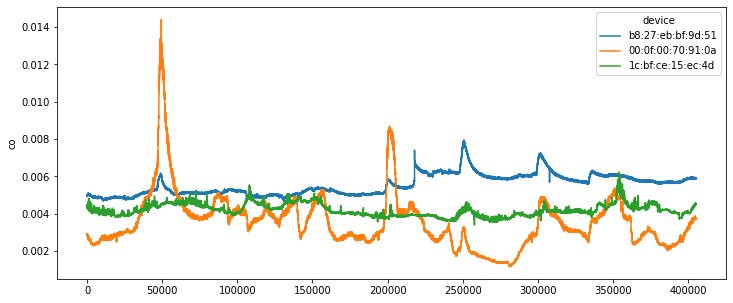

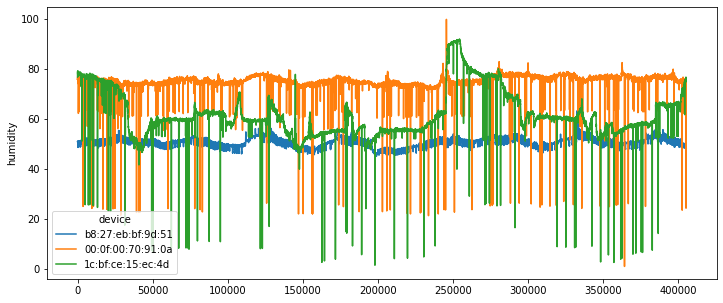

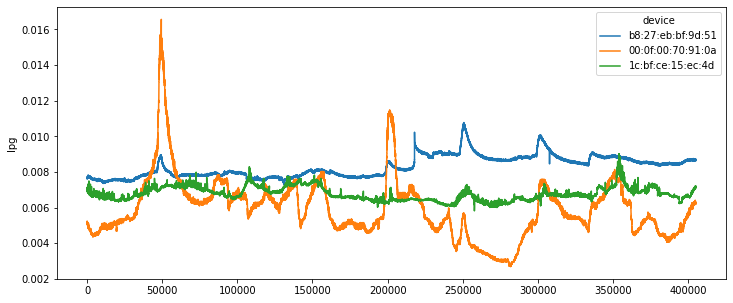

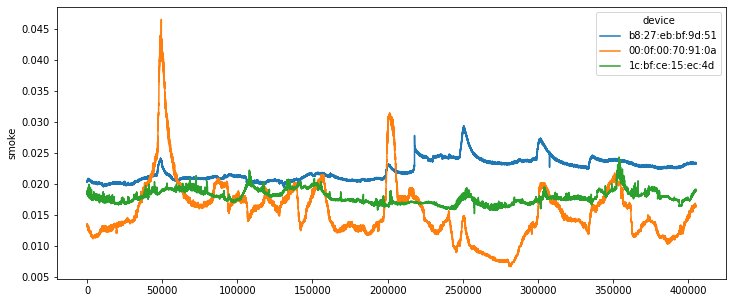

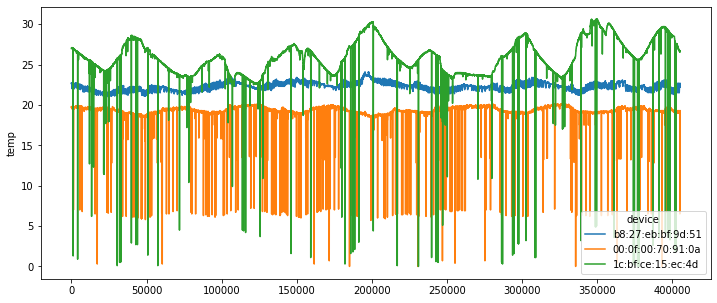

In [4]:
for col in data.select_dtypes(float).columns:
  plt.figure(figsize=(12,5))
  sns.lineplot(data=data, x=data.index, y=col, hue="device")
  plt.show()


In [5]:
devices = {
  "a": "00:0f:00:70:91:0a",
  "b": "1c:bf:ce:15:ec:4d",
  "c": "b8:27:eb:bf:9d:51"
}

data_device_a = data[data.device==devices["a"]].reset_index(drop=True).drop(columns="device")
data_device_b = data[data.device==devices["b"]].reset_index(drop=True).drop(columns="device")
data_device_c = data[data.device==devices["c"]].reset_index(drop=True).drop(columns="device")

def convert_to_timeseries(data:pd.DataFrame) -> pd.DataFrame:
  data = data.set_index("ts").resample("30s").agg(
  {'co': np.mean, 
   'humidity': np.mean, 
   "lpg": np.mean, 
   "smoke":np.mean, 
   "temp":np.mean
   }
   )
  
  data = data.fillna(data.mean())
  
  return data

def create_ts_features(data:pd.DataFrame) -> pd.DataFrame:
  data.reset_index(inplace=True)
  data["hour"] = data.ts.dt.hour
  data["day"] = data.ts.dt.dayofweek
  data["is_weekend"] =  data.ts.dt.day_name().isin(['Saturday', 'Sunday']).astype(float)
  data.set_index("ts", inplace=True)

  return data

data_device_a = convert_to_timeseries(data_device_a)
data_device_a = create_ts_features(data_device_a)

data_device_b = convert_to_timeseries(data_device_b)
data_device_b = create_ts_features(data_device_b)
data_device_c = convert_to_timeseries(data_device_c)
data_device_c = create_ts_features(data_device_c)

In [8]:
data_device_c

,co,humidity,lpg,smoke,temp,hour,day,is_weekend
ts,,,,,,,,
2020-07-12 07:01:30,0.004968,50.914286,0.007665,0.020450,22.614286,7,6,1.0
2020-07-12 07:02:00,0.004955,50.888889,0.007650,0.020409,22.600000,7,6,1.0
2020-07-12 07:02:30,0.004958,50.900000,0.007654,0.020419,22.625000,7,6,1.0
2020-07-12 07:03:00,0.004965,50.937500,0.007661,0.020441,22.637500,7,6,1.0
2020-07-12 07:03:30,0.004954,50.862500,0.007648,0.020404,22.612500,7,6,1.0
...,...,...,...,...,...,...,...,...
2020-07-20 07:01:30,0.005884,49.700000,0.008662,0.023305,22.562500,7,0,0.0
2020-07-20 07:02:00,0.005898,49.462500,0.008677,0.023348,22.487500,7,0,0.0
2020-07-20 07:02:30,0.005897,48.862500,0.008676,0.023345,22.400000,7,0,0.0


## EDA

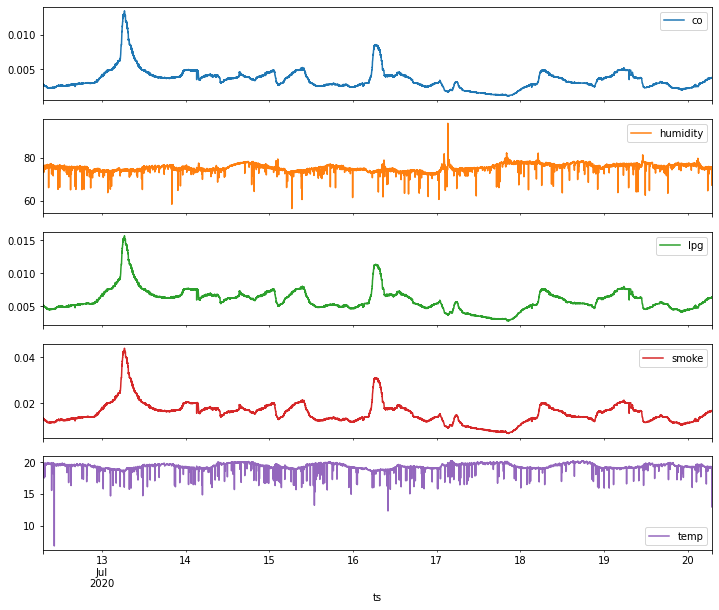

In [9]:
SENSOR_FEATURES = data_device_a.columns[:5]
data_device_a[SENSOR_FEATURES].plot(subplots=True, figsize=(12,10));

In [10]:
data_device_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23045 entries, 2020-07-12 07:01:30 to 2020-07-20 07:03:30
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   co          23045 non-null  float64
 1   humidity    23045 non-null  float64
 2   lpg         23045 non-null  float64
 3   smoke       23045 non-null  float64
 4   temp        23045 non-null  float64
 5   hour        23045 non-null  int64  
 6   day         23045 non-null  int64  
 7   is_weekend  23045 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 1.6 MB


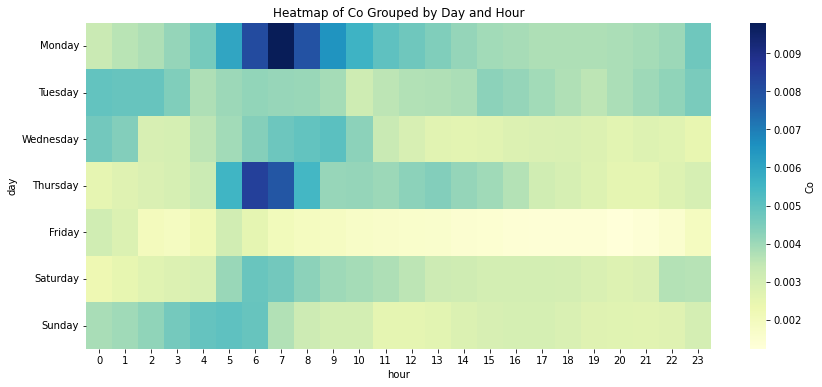

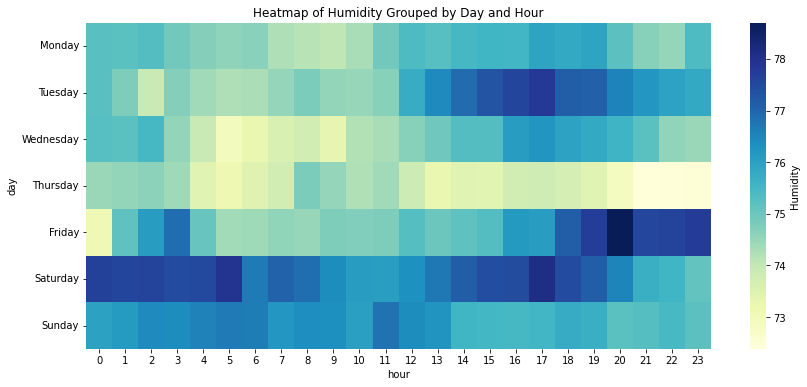

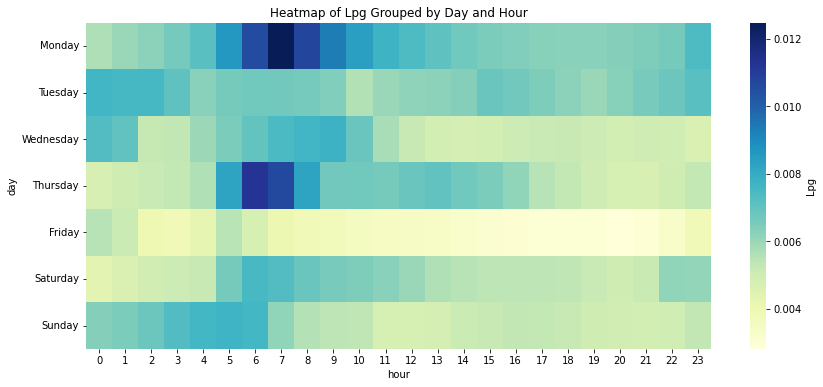

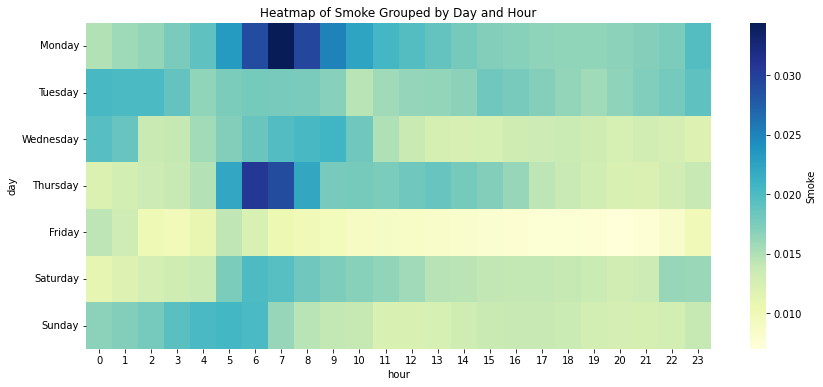

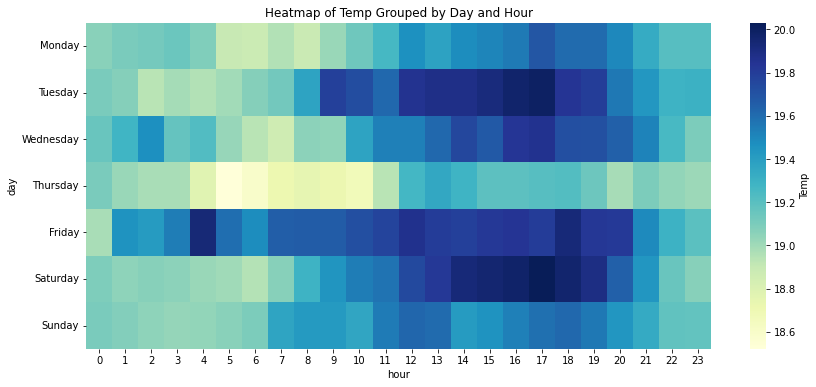

In [11]:
day_name ={
  0:"Monday",
  1:"Tuesday",
  2:"Wednesday",
  3:"Thursday",
  4:"Friday",
  5:"Saturday",
  6:"Sunday"
}

def heatmap_analysis(data:pd.DataFrame, sensor:str) -> pd.DataFrame:

  # Group by hour, day, and compute the mean of all other columns
  grouped_df = data.groupby(['hour', 'day']).mean().reset_index()

  # Pivot the DataFrame for heatmap
  pivot_table = grouped_df.pivot_table(index=['day'], columns=['hour'], values=sensor)
  pivot_table = pivot_table.reset_index().rename(day_name)#.set_index("hour")
  pivot_table.index.name="day"
  pivot_table.drop(columns="day", inplace=True)

  # Create the heatmap
  plt.figure(figsize=(14, 6))
  sns.heatmap(pivot_table, annot=False, cmap="YlGnBu", cbar_kws={'label': sensor.title()})
  plt.title(f'Heatmap of {sensor.title()} Grouped by Day and Hour')
  plt.show()

  return pivot_table

references = dict()
for col in SENSOR_FEATURES:
  references[col] = heatmap_analysis(data_device_a, col)

In [12]:
data_device_a.isnull().sum()

co            0
humidity      0
lpg           0
smoke         0
temp          0
hour          0
day           0
is_weekend    0
dtype: int64

# Modelling

## Data Pipeline

In [13]:
# data settings
used_data = data_device_a.copy()
n_data = used_data.shape[0]
ratio = .9

train_limit = int(n_data * ratio)
train_data = used_data.iloc[ :train_limit, : ]
test_data = used_data.iloc[ train_limit:, : ]

used_data_train = used_data.iloc[ :train_limit, : ]

display(train_data.head())
display(train_data.tail())
display(test_data.head())

,co,humidity,lpg,smoke,temp,hour,day,is_weekend
ts,,,,,,,,
2020-07-12 07:01:30,0.002889,76.000000,0.005178,0.013451,19.700001,7,6,1.0
2020-07-12 07:02:00,0.002886,75.900002,0.005174,0.013439,19.720000,7,6,1.0
2020-07-12 07:02:30,0.002872,75.975000,0.005156,0.013391,19.775000,7,6,1.0
2020-07-12 07:03:00,0.002861,76.039999,0.005142,0.013351,19.760000,7,6,1.0
2020-07-12 07:03:30,0.002872,76.083332,0.005156,0.013392,19.766666,7,6,1.0


,co,humidity,lpg,smoke,temp,hour,day,is_weekend
ts,,,,,,,,
2020-07-19 11:49:00,0.002374,77.779999,0.004492,0.011558,19.700001,11,6,1.0
2020-07-19 11:49:30,0.002374,77.816669,0.004493,0.011559,19.700001,11,6,1.0
2020-07-19 11:50:00,0.002371,77.883335,0.004488,0.011547,19.700001,11,6,1.0
2020-07-19 11:50:30,0.002379,62.500002,0.004499,0.011577,19.700001,11,6,1.0
2020-07-19 11:51:00,0.002375,77.800003,0.004494,0.011562,19.700001,11,6,1.0


,co,humidity,lpg,smoke,temp,hour,day,is_weekend
ts,,,,,,,,
2020-07-19 11:51:30,0.002375,77.842860,0.004494,0.011562,19.700001,11,6,1.0
2020-07-19 11:52:00,0.002375,77.850002,0.004494,0.011562,19.700001,11,6,1.0
2020-07-19 11:52:30,0.002375,77.816669,0.004494,0.011562,19.700001,11,6,1.0
2020-07-19 11:53:00,0.002367,77.733335,0.004483,0.011531,19.700001,11,6,1.0
2020-07-19 11:53:30,0.002375,77.659998,0.004494,0.011562,19.700001,11,6,1.0


> Data Scaling & Analysis 

In [14]:
# Scaling
X = train_data[SENSOR_FEATURES]

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [15]:
# data analysis
def compare_to_history(data:pd.DataFrame, sensors:list, references:dict, scaler:object) -> dict:
  """
  Checking current/input data if there is anomaly or not by using information in pivot table(heatmap) & simple statistics
  """
  std_history = {
    k:v for k,v in zip(scaler.feature_names_in_,np.sqrt(scaler.mean_))
  }

  datetime_info = pd.Series(data.index)

  dayName = datetime_info.dt.day_name()[0]
  hour = datetime_info.dt.hour[0]

  msg_info = {}
  for col in sensors:
    history_mean = references[col].loc[dayName][hour]
    std_hist = std_history[col]
    current_value = data[col].values[0]


    if not history_mean-std_hist < current_value < history_mean+std_hist:
      diff_value = current_value - history_mean
      msg_info[col] = f"Unusual value of {col} from record history, The difference is {diff_value:.2f}."
    else:
      msg_info[col] = f"Value of {col} is normal."

  return msg_info

In [17]:
def compare_to_history_v2(data:pd.DataFrame, sensors:list, references:dict, scaler:object) -> dict:
  std_history ={
    k:v for k,v in zip(scaler.feature_names_in_, np.sqrt(scaler.mean_))
  }

  datetime_info = pd.Series(data.index)

  dayName = datetime_info.dt.day_name()[0]
  hour = datetime_info.dt.hour[0]

  msg_sensor = ""
  for col in sensors:
    history_mean = references[col].loc[dayName][hour]
    std_hist = std_history[col]
    # current_value = sample[col].values[0]
    current_value = data[col].values[0]

    if not history_mean-std_hist < current_value < history_mean+std_hist:
      diff_value = current_value - history_mean
      msg_sensor += f"Unusual value of {col} from record history, There is difference of {diff_value:.2f} point."
  
  msg_info = "Current condition is Ok, all sensors behave normally" if len(msg_sensor)<1 else msg_sensor

  return msg_info

In [18]:
idx_sample = 100
sample = data_device_b.iloc[[idx_sample],:]
compare_to_history(sample, SENSOR_FEATURES, references, scaler)

{'co': 'Value of co is normal.',
 'humidity': 'Value of humidity is normal.',
 'lpg': 'Value of lpg is normal.',
 'smoke': 'Value of smoke is normal.',
 'temp': 'Unusual value of temp from record history, The difference is 7.46.'}

In [19]:
idx_sample = 100
sample = data_device_b.iloc[[idx_sample],:]
compare_to_history_v2(sample, SENSOR_FEATURES, references, scaler)

'Unusual value of temp from record history, There is difference of 7.46 point.'

In [26]:
def create_time_series_features(
        data: pd.DataFrame, 
        sensor_features: list, 
        lag_range: range, 
        target_lag: int,
        forecast: bool = False
    ):
    ts_features_target = {}
    ts_sensor_features = []
    ts_sensor_targets = []

    for feature in sensor_features:
        tmp_features = []
        for lag in lag_range:
            data[f"{feature}_lag_{lag}"] = data[feature].shift(lag)
            tmp_features.append(f"{feature}_lag_{lag}")
        ts_features_target[feature] = tmp_features
        ts_sensor_features.extend(tmp_features)
        ts_sensor_features.append(feature)
    
    if not forecast:
        for feature in sensor_features:
            data[f"{feature}_target"] = data[feature].shift(-target_lag)
            ts_features_target[feature].append(f"{feature}_target")
            ts_sensor_targets.append(f"{feature}_target")
    
    data = data.dropna()

    return data, ts_features_target#, ts_sensor_features, ts_sensor_targets

lag_range = range(1, 6)
target_lag = 5

data_transformed, TS_FEATURES_TARGET = create_time_series_features(
    used_data_train, SENSOR_FEATURES, lag_range, target_lag
)
display(TS_FEATURES_TARGET)
data_transformed.head(6)

{'co': ['co_lag_1',
  'co_lag_2',
  'co_lag_3',
  'co_lag_4',
  'co_lag_5',
  'co_target'],
 'humidity': ['humidity_lag_1',
  'humidity_lag_2',
  'humidity_lag_3',
  'humidity_lag_4',
  'humidity_lag_5',
  'humidity_target'],
 'lpg': ['lpg_lag_1',
  'lpg_lag_2',
  'lpg_lag_3',
  'lpg_lag_4',
  'lpg_lag_5',
  'lpg_target'],
 'smoke': ['smoke_lag_1',
  'smoke_lag_2',
  'smoke_lag_3',
  'smoke_lag_4',
  'smoke_lag_5',
  'smoke_target'],
 'temp': ['temp_lag_1',
  'temp_lag_2',
  'temp_lag_3',
  'temp_lag_4',
  'temp_lag_5',
  'temp_target']}

,co,humidity,lpg,smoke,temp,hour,day,is_weekend,co_lag_1,co_lag_2,...,temp_lag_1,temp_lag_2,temp_lag_3,temp_lag_4,temp_lag_5,co_target,humidity_target,lpg_target,smoke_target,temp_target
ts,,,,,,,,,,,,,,,,,,,,,
2020-07-12 07:04:00,0.002843,76.049999,0.005118,0.013285,19.750,7,6,1.0,0.002872,0.002861,...,19.766666,19.760000,19.775000,19.720000,19.700001,0.002839,75.960001,0.005113,0.013270,19.740000
2020-07-12 07:04:30,0.002832,76.133331,0.005104,0.013246,19.750,7,6,1.0,0.002843,0.002872,...,19.750000,19.766666,19.760000,19.775000,19.720000,0.002840,75.539999,0.005114,0.013275,19.799999
2020-07-12 07:05:00,0.002840,76.339998,0.005114,0.013275,19.760,7,6,1.0,0.002832,0.002843,...,19.750000,19.750000,19.766666,19.760000,19.775000,0.002812,75.560001,0.005078,0.013173,19.799999
2020-07-12 07:05:30,0.002864,76.225000,0.005146,0.013362,19.725,7,6,1.0,0.002840,0.002832,...,19.760000,19.750000,19.750000,19.766666,19.760000,0.002840,75.239999,0.005114,0.013275,19.760000
2020-07-12 07:06:00,0.002831,76.099998,0.005102,0.013241,19.740,7,6,1.0,0.002864,0.002840,...,19.725000,19.760000,19.750000,19.750000,19.766666,0.002840,75.159998,0.005114,0.013275,19.700001
2020-07-12 07:06:30,0.002839,75.960001,0.005113,0.013270,19.740,7,6,1.0,0.002831,0.002864,...,19.740000,19.725000,19.760000,19.750000,19.750000,0.002840,75.083332,0.005114,0.013275,19.700001


In [27]:
sample_col = [col for col in data_transformed.columns if "co" in col]
data_transformed[sample_col].head(11)

,co,co_lag_1,co_lag_2,co_lag_3,co_lag_4,co_lag_5,co_target
ts,,,,,,,
2020-07-12 07:04:00,0.002843,0.002872,0.002861,0.002872,0.002886,0.002889,0.002839
2020-07-12 07:04:30,0.002832,0.002843,0.002872,0.002861,0.002872,0.002886,0.002840
2020-07-12 07:05:00,0.002840,0.002832,0.002843,0.002872,0.002861,0.002872,0.002812
2020-07-12 07:05:30,0.002864,0.002840,0.002832,0.002843,0.002872,0.002861,0.002840
2020-07-12 07:06:00,0.002831,0.002864,0.002840,0.002832,0.002843,0.002872,0.002840
2020-07-12 07:06:30,0.002839,0.002831,0.002864,0.002840,0.002832,0.002843,0.002840
2020-07-12 07:07:00,0.002840,0.002839,0.002831,0.002864,0.002840,0.002832,0.002809
2020-07-12 07:07:30,0.002812,0.002840,0.002839,0.002831,0.002864,0.002840,0.002840
2020-07-12 07:08:00,0.002840,0.002812,0.002840,0.002839,0.002831,0.002864,0.002824


## Training

### Anomaly Detection / Binary Classification

In [28]:
km = KMeans(n_clusters=2, random_state=42)
km.fit(X_scaled)
used_data_train["label_km"] = km.predict(X_scaled)
display(used_data_train.label_km.value_counts(normalize=True))

dbs = DBSCAN()
dbs.fit(X_scaled)
used_data_train["label_dbs"] = dbs.labels_
used_data_train["label_dbs"] = used_data_train["label_dbs"].apply(lambda x: 0 if x==0 else -1)
display(used_data_train.label_dbs.value_counts(normalize=True))

iso = IsolationForest(random_state=42)
iso.fit(X_scaled)
used_data_train["label_iso"] = iso.predict(X_scaled)
used_data_train.label_iso.value_counts(normalize=True)

0    0.672469
1    0.327531
Name: label_km, dtype: float64

 0    0.985198
-1    0.014802
Name: label_dbs, dtype: float64

 1    0.833221
-1    0.166779
Name: label_iso, dtype: float64

,x1,x2,label_km,label_dbs,label_iso
count,2.074000e+04,2.074000e+04,20740.000000,20740.000000,20740.000000
mean,4.933373e-17,4.385220e-17,0.327531,-0.014802,0.666442
std,1.839933e+00,1.026135e+00,0.469324,0.120764,0.745575
min,-5.200346e+00,-9.919581e+00,0.000000,-1.000000,-1.000000
25%,-1.142725e+00,-6.623459e-01,0.000000,0.000000,1.000000
50%,-2.036047e-01,-4.343923e-02,0.000000,0.000000,1.000000
75%,9.233004e-01,6.302623e-01,1.000000,0.000000,1.000000
max,1.158194e+01,1.407760e+01,1.000000,0.000000,1.000000


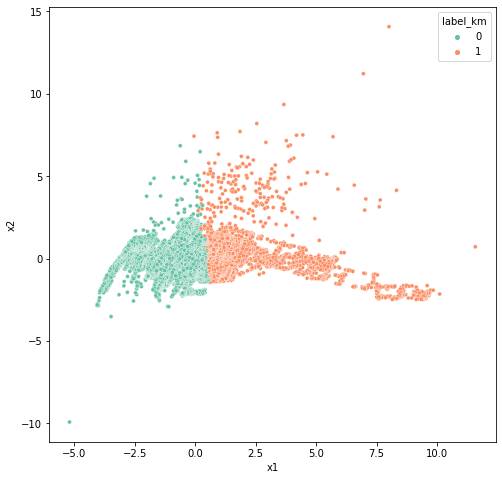

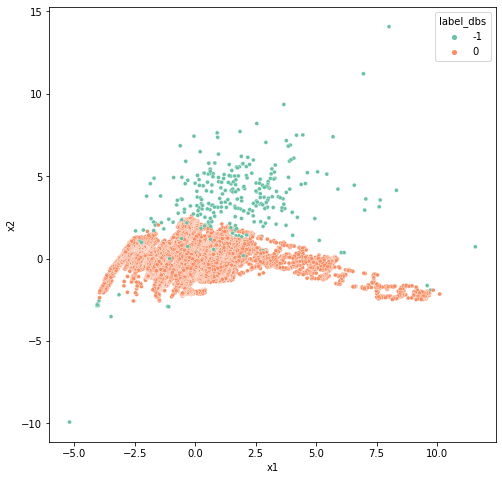

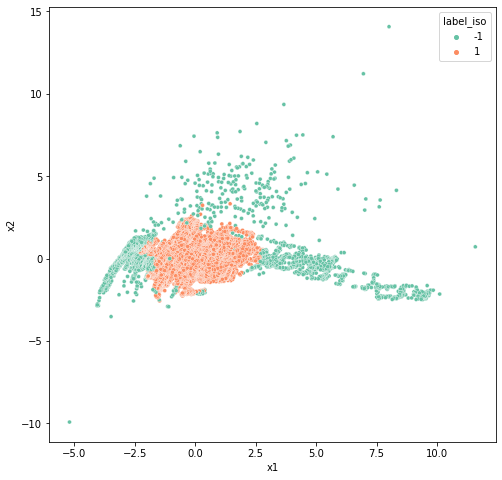

In [29]:
n = 2
pca = PCA(n, random_state=42)
# pca.fit(data_device_a[SENSOR_FEATURES])
# df_viz = pd.DataFrame(pca.transform(data_device_a[SENSOR_FEATURES]), columns=["x1", "x2"])
pca.fit(X_scaled)
df_viz = pd.DataFrame(pca.transform(X_scaled), columns=["x1", "x2"])
df_viz["label_km"] = used_data_train.label_km.values
df_viz["label_dbs"] = used_data_train.label_dbs.values
df_viz["label_iso"] = used_data_train.label_iso.values

display(df_viz.describe())
mpl.rcParams['lines.markersize'] = 4
plt.figure(figsize=(8,8))
sns.scatterplot(data=df_viz, x="x1", y="x2", hue="label_km", palette="Set2")
plt.show()

plt.figure(figsize=(8,8))
sns.scatterplot(data=df_viz, x="x1", y="x2", hue="label_dbs", palette="Set2")
plt.show()

plt.figure(figsize=(8,8))
sns.scatterplot(data=df_viz, x="x1", y="x2", hue="label_iso", palette="Set2")
plt.show()
# plt.legend()

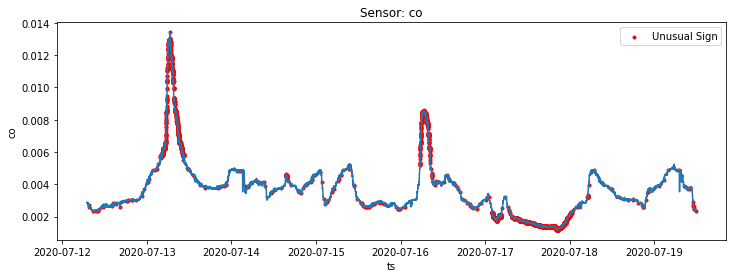

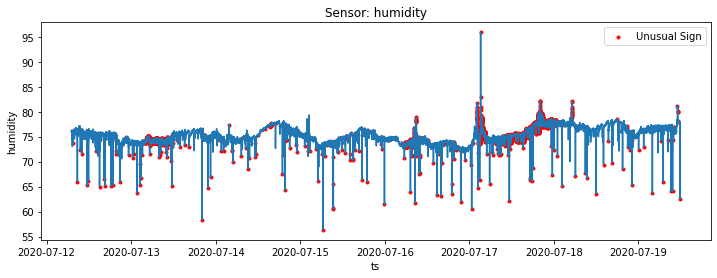

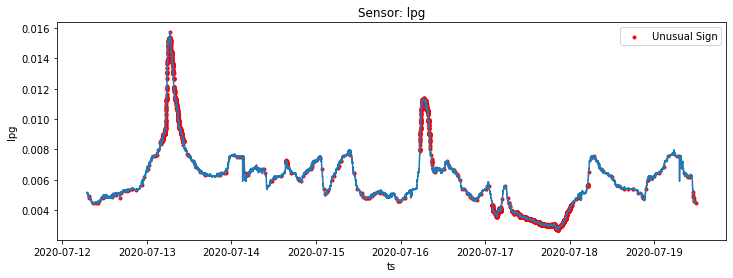

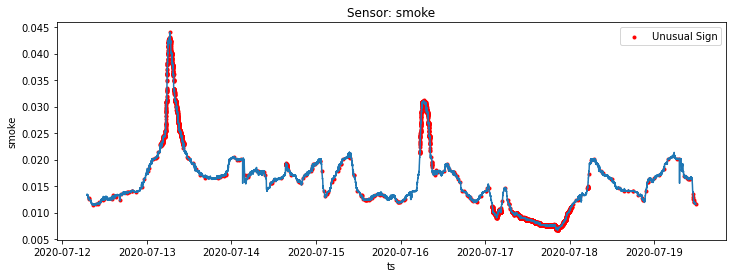

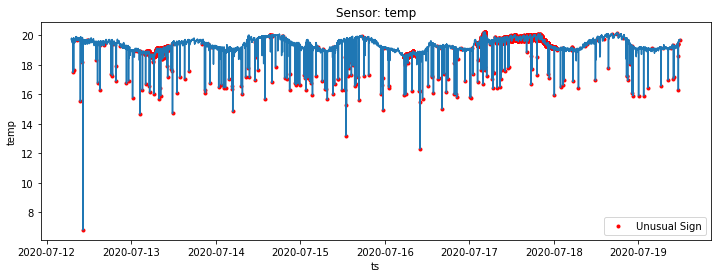

In [30]:
mpl.rcParams['lines.markersize'] = 3

for sensor in SENSOR_FEATURES:
  plt.figure(figsize=(12,4))
  tmp = used_data_train[used_data_train.label_iso==-1]
  sns.lineplot(data=used_data_train, x=used_data_train.index, y=sensor)
  plt.scatter(data=tmp, x=tmp.index, y=sensor, c="r", label="Unusual Sign")
  plt.title(f"Sensor: {sensor}")
  plt.legend()

### Forecasting

In [31]:
class SensorsForecaster(BaseEstimator, RegressorMixin):
  def __init__(self, sensors: dict, base_regressor: object):
    self.sensors = sensors
    self.base_regressor = base_regressor
    self.sensors_forecaster = {sensor: deepcopy(base_regressor) for sensor in self.sensors}

  def fit(self, X: pd.DataFrame):
    for sensor in self.sensors.keys():
      features = [c for c in self.sensors[sensor] if "lag" in c]
      target = [c for c in self.sensors[sensor] if "target" in c]
      X_ = X[features]
      y = X[target].values.ravel()
      self.sensors_forecaster[sensor].fit(X_, y)
    return self

  def predict(self, X):
    if isinstance(X, pd.Series):
      X = X.to_frame().T
    
    idx = X.index + pd.Timedelta(seconds=150)

    prediction = {}
    for sensor in self.sensors.keys():
      features = [c for c in self.sensors[sensor] if "lag" in c]
      X_ = X[features]
      prediction[sensor] = self.sensors_forecaster[sensor].predict(X_)
  
    df_prediction = pd.DataFrame(prediction, index=idx)
    df_prediction.index.name = "ts"

    if isinstance(X, pd.Series):
      return df_prediction.iloc[0]
    
    return df_prediction

In [32]:
# data processing
forecaster_input_train, TS_FEATURES_TARGET = create_time_series_features(
    used_data_train, SENSOR_FEATURES, lag_range, target_lag
)

# fitting data
MyForecaster = SensorsForecaster(sensors=TS_FEATURES_TARGET, base_regressor=LinearRegression())
MyForecaster.fit(forecaster_input_train)

SensorsForecaster(base_regressor=LinearRegression(),
                  sensors={'co': ['co_lag_1', 'co_lag_2', 'co_lag_3',
                                  'co_lag_4', 'co_lag_5', 'co_target'],
                           'humidity': ['humidity_lag_1', 'humidity_lag_2',
                                        'humidity_lag_3', 'humidity_lag_4',
                                        'humidity_lag_5', 'humidity_target'],
                           'lpg': ['lpg_lag_1', 'lpg_lag_2', 'lpg_lag_3',
                                   'lpg_lag_4', 'lpg_lag_5', 'lpg_target'],
                           'smoke': ['smoke_lag_1', 'smoke_lag_2',
                                     'smoke_lag_3', 'smoke_lag_4',
                                     'smoke_lag_5', 'smoke_target'],
                           'temp': ['temp_lag_1', 'temp_lag_2', 'temp_lag_3',
                                    'temp_lag_4', 'temp_lag_5',
                                    'temp_target']})

In [34]:
# display(used_data_train.iloc[100:106,:])
sample_input, TS_FEATURES_TARGET = create_time_series_features(
    used_data_train.iloc[100:106,:], SENSOR_FEATURES, lag_range, target_lag, True
)
display(sample_input)
MyForecaster.predict(sample_input)

,co,humidity,lpg,smoke,temp,hour,day,is_weekend,co_lag_1,co_lag_2,...,temp_lag_4,temp_lag_5,co_target,humidity_target,lpg_target,smoke_target,temp_target,label_km,label_dbs,label_iso
ts,,,,,,,,,,,,,,,,,,,,,
2020-07-12 07:54:00,0.002584,74.800001,0.004777,0.012341,19.5,7,6,1.0,0.002598,0.002613,...,19.6,19.6,0.002607,75.380002,0.004807,0.012424,19.52,0,0,1


,co,humidity,lpg,smoke,temp
ts,,,,,
2020-07-12 07:56:30,0.002601,74.699472,0.0048,0.012405,19.559277


# Deployment

## Testing

In [35]:
test_data_ = data_device_b.copy()
start_idx, end_idx = 0, 6
sample_test_data = test_data_.iloc[start_idx:end_idx, : ]
display(sample_test_data)

,co,humidity,lpg,smoke,temp,hour,day,is_weekend
ts,,,,,,,,
2020-07-12 07:01:30,0.004395,77.720001,0.007014,0.018601,27.0,7,6,1.0
2020-07-12 07:02:00,0.004389,78.000002,0.007007,0.018581,27.0,7,6,1.0
2020-07-12 07:02:30,0.004390,78.399999,0.007009,0.018587,27.0,7,6,1.0
2020-07-12 07:03:00,0.004383,78.600000,0.007001,0.018564,27.0,7,6,1.0
2020-07-12 07:03:30,0.004401,78.219998,0.007020,0.018620,27.0,7,6,1.0
2020-07-12 07:04:00,0.004437,78.079999,0.007062,0.018739,27.0,7,6,1.0


In [36]:
anomaly_input_scaled = scaler.transform(sample_test_data[SENSOR_FEATURES])
anomaly_input = sample_test_data[SENSOR_FEATURES]
iso.predict(anomaly_input_scaled), iso.predict(anomaly_input)

(array([-1, -1, -1, -1, -1, -1]), array([-1, -1, -1, -1, -1, -1]))

In [37]:
for i in range(sample_test_data.shape[0]):
  display(sample_test_data.iloc[i,:].to_frame().T)
  print(compare_to_history_v2(sample_test_data.iloc[i,:].to_frame().T, SENSOR_FEATURES, references, scaler))
  print()
  print()

,co,humidity,lpg,smoke,temp,hour,day,is_weekend
2020-07-12 07:01:30,0.004395,77.720001,0.007014,0.018601,27.0,7.0,6.0,1.0


Unusual value of temp from record history, There is difference of 7.63 point.




,co,humidity,lpg,smoke,temp,hour,day,is_weekend
2020-07-12 07:02:00,0.004389,78.000002,0.007007,0.018581,27.0,7.0,6.0,1.0


Unusual value of temp from record history, There is difference of 7.63 point.




,co,humidity,lpg,smoke,temp,hour,day,is_weekend
2020-07-12 07:02:30,0.00439,78.399999,0.007009,0.018587,27.0,7.0,6.0,1.0


Unusual value of temp from record history, There is difference of 7.63 point.




,co,humidity,lpg,smoke,temp,hour,day,is_weekend
2020-07-12 07:03:00,0.004383,78.6,0.007001,0.018564,27.0,7.0,6.0,1.0


Unusual value of temp from record history, There is difference of 7.63 point.




,co,humidity,lpg,smoke,temp,hour,day,is_weekend
2020-07-12 07:03:30,0.004401,78.219998,0.00702,0.01862,27.0,7.0,6.0,1.0


Unusual value of temp from record history, There is difference of 7.63 point.




,co,humidity,lpg,smoke,temp,hour,day,is_weekend
2020-07-12 07:04:00,0.004437,78.079999,0.007062,0.018739,27.0,7.0,6.0,1.0


Unusual value of temp from record history, There is difference of 7.63 point.




In [38]:
sample_test_data_ts, TS_FEATURES_TARGET = create_time_series_features(
    sample_test_data, SENSOR_FEATURES, lag_range, target_lag, True
)
display(sample_test_data_ts)

test_data_forecasted = MyForecaster.predict(sample_test_data_ts)
test_data_forecasted

,co,humidity,lpg,smoke,temp,hour,day,is_weekend,co_lag_1,co_lag_2,...,smoke_lag_1,smoke_lag_2,smoke_lag_3,smoke_lag_4,smoke_lag_5,temp_lag_1,temp_lag_2,temp_lag_3,temp_lag_4,temp_lag_5
ts,,,,,,,,,,,,,,,,,,,,,
2020-07-12 07:04:00,0.004437,78.079999,0.007062,0.018739,27.0,7,6,1.0,0.004401,0.004383,...,0.01862,0.018564,0.018587,0.018581,0.018601,27.0,27.0,27.0,27.0,27.0


,co,humidity,lpg,smoke,temp
ts,,,,,
2020-07-12 07:06:30,0.004394,77.980775,0.007013,0.018599,26.135361


In [39]:
iso.predict(test_data_forecasted)

array([-1])

In [40]:
compare_to_history_v2(test_data_forecasted, SENSOR_FEATURES, references, scaler)

'Unusual value of temp from record history, There is difference of 6.76 point.'

## Saving Objects

In [41]:
with open("models/km.bin", "wb") as f:
  pickle.dump(km, f)
  
with open("models/iso_forest.bin", "wb") as f:
  pickle.dump(iso, f)

with open("models/forecaster.bin", "wb") as f:
  pickle.dump(MyForecaster, f)

with open ("data/sensor_features.bin", "wb") as f:
  pickle.dump(SENSOR_FEATURES, f)

with open ("data/references.bin", "wb") as f:
  pickle.dump(references, f)

with open ("data/scaler.bin", "wb") as f:
  pickle.dump(scaler, f)

data_device_a.to_parquet("data/device_a.parquet")
data_device_b.to_parquet("data/device_b.parquet")
data_device_c.to_parquet("data/device_c.parquet")